# What is the differences between RNN & LSTM?

Before I tell you what is LSTM let me tell you about the biggest problem with RNNs. So far everything looks good about RNNs until we train it via back-propagation. As the gradient of our training samples gets propagated backward through our network, it gets weaker and weaker, by the time it gets to those neurons that represent older data points in our time-series it has no juice to adjust them properly. This problem is called Vanishing Gradient. A LSTM cell is a type of RNN which stores important information about the past and forgets the unimportant pieces. In this way, when gradient back-propagates, it won’t be consumed by unnecessary information.

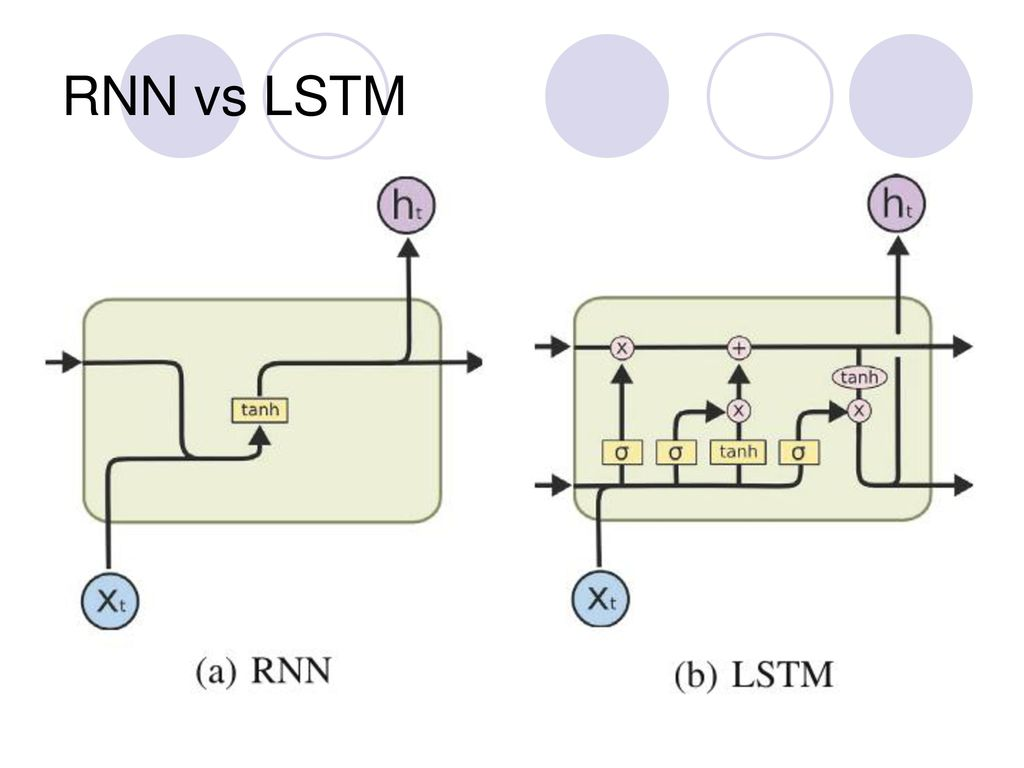

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [110]:
bit_data=pd.read_csv("C:/Users/Nikhil/Desktop/deeplerning/data/bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv")
bit_data["date"]=pd.to_datetime(bit_data['Timestamp'],unit='s').dt.date
#Added a column "date" and converted 'Timestamp' to date form
group=bit_data.groupby('date')
#Group the data by Dates
data=group["Close"].mean()
#Taking the mean value of all 'Close' values which is on same date

In [111]:
bit_data.shape


(3778817, 9)

In [76]:
bit_data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
...,...,...,...,...,...,...,...,...,...
3778812,1552434960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-12
3778813,1552435020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-12
3778814,1552435080,3860.09,3861.05,3860.09,3861.05,0.378637,1461.770077,3860.606378,2019-03-12
3778815,1552435140,3860.18,3860.18,3859.74,3859.74,1.056403,4077.863045,3860.139080,2019-03-12


In [82]:
data.shape


(2627,)

In [112]:
data

date
2011-12-31       4.482500
2012-01-01       4.806667
2012-01-02       5.000000
2012-01-03       5.252500
2012-01-04       5.223333
                 ...     
2019-03-09    3891.321675
2019-03-10    3892.723138
2019-03-11    3862.935306
2019-03-12    3847.332864
2019-03-13    3861.950000
Name: Close, Length: 2627, dtype: float64

In [84]:
data.isnull()
#It is used to detect if any Data is missing.
#If Data is missing it return 'True' else 'False'

date
2011-12-31    False
2012-01-01    False
2012-01-02    False
2012-01-03    False
2012-01-04    False
              ...  
2019-03-09    False
2019-03-10    False
2019-03-11    False
2019-03-12    False
2019-03-13    False
Name: Close, Length: 2627, dtype: bool

The goal is making prediction of daily "Close" data.
So,we predict "Close" value of Bitcoin data.

# RNN to predict 

In [85]:
bit_train=data.iloc[:len(data)-100]   
bit_test=data.iloc[len(bit_train):]
#After leaving last 100 data put all data in Training set
#Put last 100 data in Test set
bit_train.shape

(2527,)

Set the values between 0 and 1 to avoid dominance of bigger value


In [86]:
#Feature Scaling(set values between 0 and 1)
bit_train=np.array(bit_train)
print(bit_train.shape)
bit_train=bit_train.reshape(bit_train.shape[0],1)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
bit_scaled=scaler.fit_transform(bit_train)

(2527,)


Let's choose every 50 data as x_train and 51th as y_train


In [87]:
timestep=50
x_train=[]
y_train=[]

for i in range(timestep,bit_scaled.shape[0]):
    x_train.append(bit_scaled[i-timestep:i,0])
    y_train.append(bit_scaled[i,0])
    
x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)#Reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (2477, 50, 1)
y_train shape=  (2477,)


In [88]:
x_train

array([[[7.86163155e-06],
        [2.47576242e-05],
        [3.48344116e-05],
        ...,
        [1.27135127e-05],
        [1.87256680e-05],
        [3.44134318e-06]],

       [[2.47576242e-05],
        [3.48344116e-05],
        [4.79950434e-05],
        ...,
        [1.87256680e-05],
        [3.44134318e-06],
        [0.00000000e+00]],

       [[3.48344116e-05],
        [4.79950434e-05],
        [4.64748384e-05],
        ...,
        [3.44134318e-06],
        [0.00000000e+00],
        [1.19382629e-05]],

       ...,

       [[3.22995706e-01],
        [3.22705065e-01],
        [3.24289231e-01],
        ...,
        [2.11258481e-01],
        [2.19990957e-01],
        [2.12151107e-01]],

       [[3.22705065e-01],
        [3.24289231e-01],
        [3.32095304e-01],
        ...,
        [2.19990957e-01],
        [2.12151107e-01],
        [2.12530188e-01]],

       [[3.24289231e-01],
        [3.32095304e-01],
        [3.35325922e-01],
        ...,
        [2.12151107e-01],
        [2.1253

In [89]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout,Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [90]:
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D , LeakyReLU
from keras.layers import Flatten, Lambda, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU

In [91]:
R_model=Sequential()
#First RNN layer
R_model.add(SimpleRNN(20,activation='relu',return_sequences=True,input_shape=(x_train.shape[1],1)))
R_model.add(Dropout(1))

R_model.add(SimpleRNN(256,activation='relu',return_sequences=True))
R_model.add(Dropout(0.25))

R_model.add(SimpleRNN(512,activation='relu',return_sequences=True))
R_model.add(Dropout(0.35))

#R_model.add(SimpleRNN(20,activation='relu',return_sequences=True))
#R_model.add(Dropout(1))

R_model.add(SimpleRNN(20,activation='relu',return_sequences=True))
            
R_model.add(Dropout(1))
#Convert the matrix to 1-line
R_model.add(Flatten())
#Output layer
R_model.add(Dense(1))



In [92]:
es = EarlyStopping(monitor='val_loss',min_delta = 0.0005,patience =5,restore_best_weights=False)
#cp = ModelCheckpoint(filepath ='best_model.h5', monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False, mode='max')
#rLRoP = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callback = [es]#,cp,rLRoP];

In [93]:
R_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [94]:
R_history=R_model.fit(x_train,y_train,epochs=100,batch_size=64,callbacks=callback)

Epoch 1/100
2477/2477 [==============================] - 14s 6ms/step - loss: 0.0058 - accuracy: 8.0743e-04
Epoch 2/100


C:\Users\Nikhil\.conda\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2477/2477 [==============================] - 14s 6ms/step - loss: 0.0015 - accuracy: 8.0743e-04
Epoch 3/100
2477/2477 [==============================] - 14s 6ms/step - loss: 9.9887e-04 - accuracy: 8.0743e-04
Epoch 4/100
2477/2477 [==============================] - 14s 6ms/step - loss: 0.0011 - accuracy: 8.0743e-04
Epoch 5/100
2477/2477 [==============================] - 14s 6ms/step - loss: 7.9357e-04 - accuracy: 8.0743e-04
Epoch 6/100
2477/2477 [==============================] - 13s 5ms/step - loss: 9.4388e-04 - accuracy: 8.0743e-04
Epoch 7/100
2477/2477 [==============================] - 14s 5ms/step - loss: 6.2198e-04 - accuracy: 8.0743e-04
Epoch 8/100
2477/2477 [==============================] - 14s 6ms/step - loss: 6.2985e-04 - accuracy: 8.0743e-04
Epoch 9/100
2477/2477 [==============================] - 14s 6ms/step - loss: 5.4017e-04 - accuracy: 8.0743e-04
Epoch 10/100
2477/2477 [==============================] - 15s 6ms/step - loss: 0.0011 - accuracy: 8.0743e-04
Epoch 11/100
24

2477/2477 [==============================] - 14s 6ms/step - loss: 1.2758e-04 - accuracy: 8.0743e-04
Epoch 75/100
2477/2477 [==============================] - 14s 5ms/step - loss: 1.2552e-04 - accuracy: 8.0743e-04
Epoch 76/100
2477/2477 [==============================] - 15s 6ms/step - loss: 1.1666e-04 - accuracy: 8.0743e-04
Epoch 77/100
2477/2477 [==============================] - 14s 6ms/step - loss: 1.2900e-04 - accuracy: 8.0743e-04
Epoch 78/100
2477/2477 [==============================] - 16s 6ms/step - loss: 1.9163e-04 - accuracy: 8.0743e-04
Epoch 79/100
2477/2477 [==============================] - 14s 6ms/step - loss: 1.4153e-04 - accuracy: 8.0743e-04
Epoch 80/100
2477/2477 [==============================] - 14s 6ms/step - loss: 1.5666e-04 - accuracy: 8.0743e-04
Epoch 81/100
2477/2477 [==============================] - 15s 6ms/step - loss: 1.7270e-04 - accuracy: 8.0743e-04
Epoch 82/100
2477/2477 [==============================] - 15s 6ms/step - loss: 1.4622e-04 - accuracy: 8.0743e

In [95]:
print(R_history.history.keys())

dict_keys(['loss', 'accuracy'])


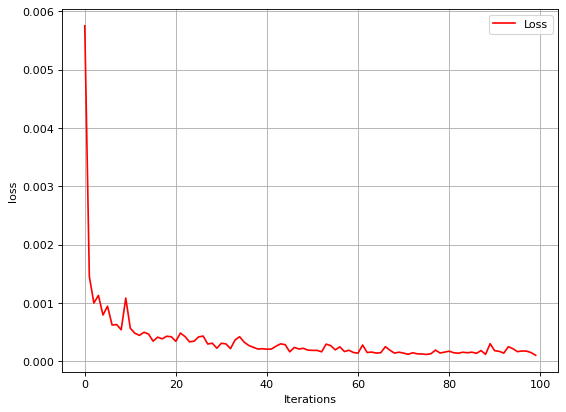

In [96]:
plt.figure(figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(R_history.history["loss"],color="r",label="Loss")
#plt.plot(R_history.history["acc"],color="b",label="Accur")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("loss")
plt.grid(True)
plt.show()

Testing with Test set

In [102]:
inputs=data[len(data)-len(bit_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [104]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)
x_test.shape

(100, 50, 1)

In [113]:
predicted_data_RNN=R_model.predict(x_test)
predicted_data_RNN=scaler.inverse_transform(predicted_data_RNN)

In [114]:
data_test=np.array(bit_test)
data_test=data_test.reshape(len(bit_test),1)

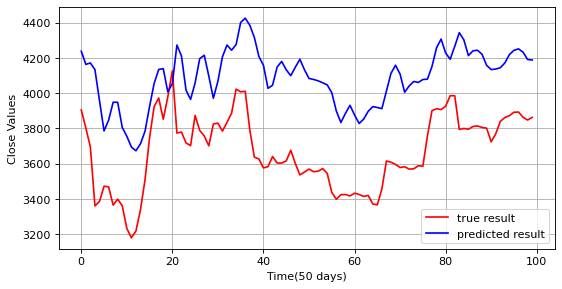

In [125]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data_RNN,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

Here we can see that the results of our prediction with RNN model is not so good.
So let's predict the results with LSTM model.
Here we use same Training set and Test set

# LSTM to predict

In [168]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,Flatten


In [169]:
x_train.shape

(2477, 50, 1)

In [208]:
S_model=Sequential()

S_model.add(LSTM(30,activation="relu",input_shape=(None,1)))
#S_model.add(LSTM(10,activation='relu'))
S_model.add(Dense(1))

In [209]:
S_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [210]:
S_history=S_model.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
2477/2477 [==============================] - 2s 621us/step - loss: 0.0107 - accuracy: 8.0743e-04
Epoch 2/100
2477/2477 [==============================] - 2s 957us/step - loss: 7.7534e-04 - accuracy: 8.0743e-04
Epoch 3/100
2477/2477 [==============================] - 2s 763us/step - loss: 5.6966e-04 - accuracy: 8.0743e-04
Epoch 4/100
2477/2477 [==============================] - 2s 749us/step - loss: 5.0235e-04 - accuracy: 8.0743e-04
Epoch 5/100
2477/2477 [==============================] - 3s 1ms/step - loss: 4.1084e-04 - accuracy: 8.0743e-04
Epoch 6/100
2477/2477 [==============================] - 3s 1ms/step - loss: 3.9200e-04 - accuracy: 8.0743e-04
Epoch 7/100
2477/2477 [==============================] - 3s 1ms/step - loss: 3.5025e-04 - accuracy: 8.0743e-04
Epoch 8/100
2477/2477 [==============================] - 3s 1ms/step - loss: 3.2754e-04 - accuracy: 8.0743e-04
Epoch 9/100
2477/2477 [==============================] - 2s 928us/step - loss: 3.0979e-04 - accuracy: 8.0743

2477/2477 [==============================] - 2s 970us/step - loss: 1.0420e-04 - accuracy: 8.0743e-04
Epoch 73/100
2477/2477 [==============================] - 2s 959us/step - loss: 1.1073e-04 - accuracy: 8.0743e-04
Epoch 74/100
2477/2477 [==============================] - 1s 481us/step - loss: 1.1036e-04 - accuracy: 8.0743e-04
Epoch 75/100
2477/2477 [==============================] - 3s 1ms/step - loss: 1.0977e-04 - accuracy: 8.0743e-04
Epoch 76/100
2477/2477 [==============================] - 2s 979us/step - loss: 1.0120e-04 - accuracy: 8.0743e-04
Epoch 77/100
2477/2477 [==============================] - 2s 971us/step - loss: 1.1925e-04 - accuracy: 8.0743e-04
Epoch 78/100
2477/2477 [==============================] - 2s 982us/step - loss: 1.2480e-04 - accuracy: 8.0743e-04
Epoch 79/100
2477/2477 [==============================] - 2s 981us/step - loss: 1.0486e-04 - accuracy: 8.0743e-040s - loss: 1.023
Epoch 80/100
2477/2477 [==============================] - 2s 978us/step - loss: 9.4530e

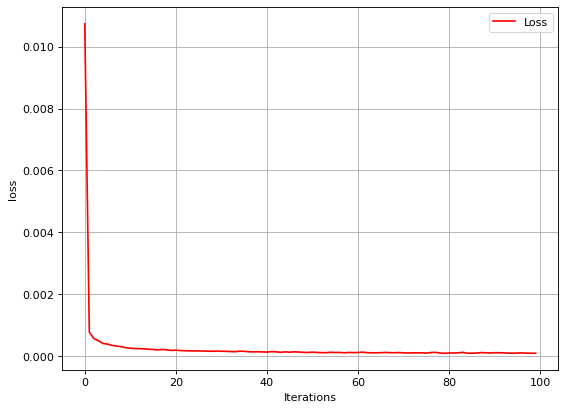

In [211]:
plt.figure(figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(S_history.history["loss"],color="r",label="Loss")
#plt.plot(R_history.history["acc"],color="b",label="Accur")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("loss")
plt.grid(True)
plt.show()

Testing with Test data

In [212]:
inputs=data[len(data)-len(bit_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [213]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [214]:
predicted_data_LSTM=S_model.predict(x_test)
predicted_data_LSTM=scaler.inverse_transform(predicted_data_LSTM)

In [215]:
data_test=np.array(bit_test)
data_test=data_test.reshape(len(data_test),1)

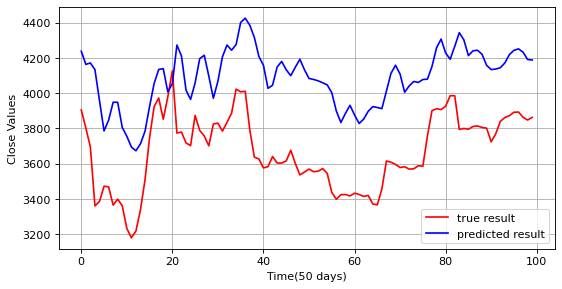

In [216]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

In [217]:
data_test=np.array(bit_test)
data_test=data_test.reshape(len(data_test),1)

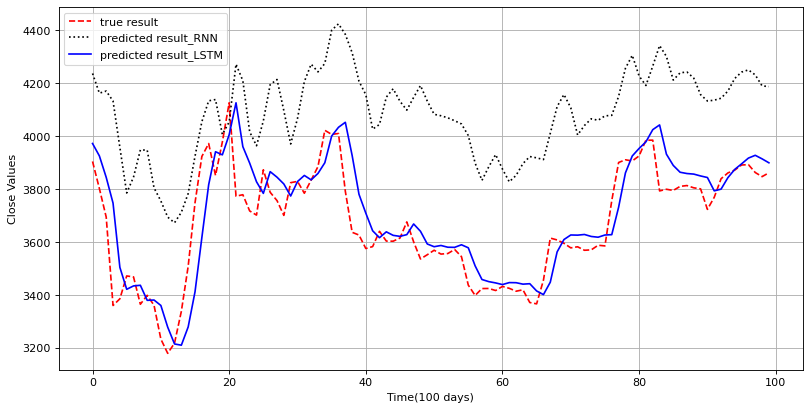

In [218]:
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result",linestyle = '--')
plt.plot(predicted_data_RNN,color="k",label="predicted result_RNN",linestyle = ':')
plt.plot(predicted_data_LSTM,color="b",label="predicted result_LSTM")
#plt.plot(predicted_data_LSTM2,color="r",label="predicted result_LSTM2")
plt.legend()
plt.xlabel("Time(100 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

# Conclusion

When we compare the both results (RNN and LSTM).

we can see that we have better prediction with LSTM.